# v1-5 Pre-training
https://www.tensorflow.org/tutorials/images/transfer_learning?hl=ko

1. Code, image 정리
2. Epochs 추가
3. img_height, img_width 변경 (180 -> 128)
4. Pre-training: 높은 initial value (EfficientNetB5)
5. Fine-tuning 예정

In [1]:
exp_name = 'v1-5'

from util import *
%load_ext autoreload
%autoreload 2
%matplotlib inline

# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
# os.environ["CUDA_VISIBLE_DEVICES"]="0"
try:
    for gpu in tf.config.experimental.list_physical_devices('GPU'):
        tf.config.experimental.set_memory_growth(gpu, True)
except RuntimeError as e:
    print(e)

In [10]:
model_name = 'EfficientNetB5'

if model_name == 'EfficientNetB0':
    img_height = 128  # EfficientNetB0
    img_width  = 128
    batch_size = 128
elif model_name == 'EfficientNetB5':
    img_height = 456  # EfficientNetB5
    img_width  = 456
    batch_size = 128
else:
    raise ValueError

    
img_size   = (img_height, img_width)
RS         = 42

In [11]:
data_dir = join(PATH.INPUT, 'train')
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, validation_split=0.2, subset='training', shuffle=True, seed=RS, image_size=img_size, batch_size=batch_size
)
val_ds   = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, validation_split=0.2, subset='validation', shuffle=True, seed=RS, image_size=img_size, batch_size=batch_size
)
full_ds  = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, shuffle=True, seed=RS, image_size=img_size, batch_size=batch_size
)

class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break
    
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
full_ds  = full_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 13861 files belonging to 9 classes.
Using 11089 files for training.
Found 13861 files belonging to 9 classes.
Using 2772 files for validation.
Found 13861 files belonging to 9 classes.
['Tomato_D01', 'Tomato_D04', 'Tomato_D05', 'Tomato_D07', 'Tomato_D08', 'Tomato_D09', 'Tomato_H', 'Tomato_P03', 'Tomato_P05']
(32, 456, 456, 3)
(32,)


In [4]:
from tensorflow.keras import layers

mirrored_strategy = tf.distribute.MirroredStrategy()
with mirrored_strategy.scope():
    data_augmentation = Sequential([
        layers.experimental.preprocessing.RandomFlip('horizontal', input_shape=(img_height, img_width, 3)),
        layers.experimental.preprocessing.RandomRotation(0.1),
        layers.experimental.preprocessing.RandomZoom(0.1)
    ])
#     rescale = layers.experimental.preprocessing.Rescaling(1./255)  # EfficientNet: [0, 255]


    img_shape = img_size + (3,)

    model = eval('keras.applications.'+model_name)
    base_model = model(input_shape=img_shape, include_top=False, weights='imagenet')
#     base_model = model(input_shape=img_shape, include_top=False, weights=f'{model_name.lower()}_notop.h5')
    base_model.trainable = False


    image_batch, label_batch = next(iter(train_ds))
    feature_batch = base_model(image_batch)
    print(feature_batch.shape)

    global_average_layer = layers.GlobalAveragePooling2D()
    feature_batch_average = global_average_layer(feature_batch)
    print(feature_batch_average.shape)

    prediction_layer = layers.Dense(num_classes)
    prediction_batch = prediction_layer(feature_batch_average)
    print(prediction_batch.shape)


    inputs = keras.Input(shape=(img_height, img_width, 3))
    
    x = data_augmentation(inputs)
    x = base_model(x, training=False)
    x = global_average_layer(x)
    x = layers.Dropout(0.2)(x)
    outputs = prediction_layer(x)
    model = keras.Model(inputs, outputs)

    # optimizer = keras.optimizers.RMSprop(learning_rate=base_learning_rate)  # base_learning_rate = 1e-3
    optimizer = keras.optimizers.Adam()  # learning_rate=0.0005, beta2=0.99999
    model.compile(optimizer=optimizer, loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
    model.summary()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task

In [ ]:
# from tensorflow.keras.callbacks import EarlyStopping

# epochs = 100
# history = model.fit(
#     train_ds, validation_data=val_ds, epochs=epochs,
#     callbacks=[EarlyStopping(monitor='val_loss', mode='min', patience=20)]
# )

In [5]:
epochs = 30
history = model.fit(
    full_ds, epochs=epochs, 
)

Epoch 1/30
INFO:tensorflow:batch_all_reduce: 2 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 2 all-reduces with algorithm = nccl, num_packs = 1
109/109 [==============================] - 82s 367ms/step - loss: 0.8412 - accuracy: 0.7383
Epoch 2/30
109/109 [==============================] - 38s 345ms/step - loss: 0.5169 - accuracy: 0.8538
Epoch 3/30
109/109 [==============================] - 37s 343ms/step - loss: 0.4286 - accuracy: 0.8787
Epoch 4/30
109/109 [==============================] - 38s 346ms/step - loss: 0.3794 - accuracy: 0.8938
Epoch 5/30
109/109 [==============================] - 38s 345ms/step - loss: 0.3469 - accuracy: 0.9024
Epoch 6/30
109/109 [==============================] - 37s 344ms/step - loss: 0.3228 - accuracy: 0.9084
Epoch 7/30
109/109 [==============================] - 38s 345ms/step - loss: 0.3012 - accuracy: 0.9126
Epoch 8/30
109/109 [==============================] - 38s 345ms/step - loss: 0.2908 - accuracy: 0.9141
Epoch 

In [12]:
epochs = 20
history = model.fit(
    full_ds, epochs=epochs, 
)

Epoch 1/20
434/434 [==============================] - 60s 137ms/step - loss: 0.1676 - accuracy: 0.9435
Epoch 2/20
434/434 [==============================] - 48s 111ms/step - loss: 0.1618 - accuracy: 0.9479
Epoch 3/20
434/434 [==============================] - 48s 110ms/step - loss: 0.1615 - accuracy: 0.9459
Epoch 4/20
434/434 [==============================] - 48s 111ms/step - loss: 0.1520 - accuracy: 0.9499
Epoch 5/20
434/434 [==============================] - 48s 110ms/step - loss: 0.1511 - accuracy: 0.9497
Epoch 6/20
434/434 [==============================] - 48s 110ms/step - loss: 0.1568 - accuracy: 0.9504
Epoch 7/20
434/434 [==============================] - 48s 110ms/step - loss: 0.1480 - accuracy: 0.9501
Epoch 8/20
434/434 [==============================] - 48s 111ms/step - loss: 0.1543 - accuracy: 0.9486
Epoch 9/20
434/434 [==============================] - 48s 111ms/step - loss: 0.1514 - accuracy: 0.9489
Epoch 10/20
434/434 [==============================] - 48s 111ms/step - l

In [14]:
epochs = 50
history = model.fit(
    full_ds, epochs=epochs, 
)

Epoch 1/50
434/434 [==============================] - 48s 111ms/step - loss: 0.1387 - accuracy: 0.9537
Epoch 2/50
434/434 [==============================] - 48s 111ms/step - loss: 0.1416 - accuracy: 0.9522
Epoch 3/50
434/434 [==============================] - 48s 110ms/step - loss: 0.1371 - accuracy: 0.9530
Epoch 4/50
434/434 [==============================] - 48s 110ms/step - loss: 0.1402 - accuracy: 0.9507
Epoch 5/50
434/434 [==============================] - 48s 110ms/step - loss: 0.1387 - accuracy: 0.9534
Epoch 6/50
434/434 [==============================] - 48s 111ms/step - loss: 0.1384 - accuracy: 0.9535
Epoch 7/50
434/434 [==============================] - 48s 111ms/step - loss: 0.1401 - accuracy: 0.9548
Epoch 8/50
434/434 [==============================] - 48s 110ms/step - loss: 0.1405 - accuracy: 0.9538
Epoch 9/50
434/434 [==============================] - 48s 111ms/step - loss: 0.1448 - accuracy: 0.9504
Epoch 10/50
434/434 [==============================] - 48s 111ms/step - l

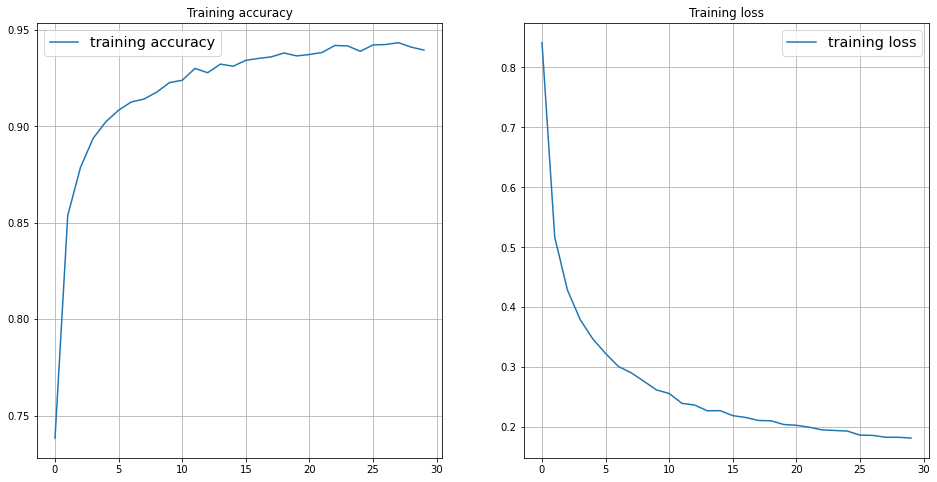

In [7]:
hist         = history.history
epochs_range = range(len(hist['loss']))

plt.figure(figsize=(16, 8))
if 'val_loss' in hist:
    for idx, metric in enumerate(['accuracy', 'loss']):
        train_metric = hist[metric]
        val_metric   = hist[f'val_{metric}']

        plt.subplot(1, 2, idx+1)
        plt.plot(epochs_range, train_metric, label=f'training {metric}')
        plt.plot(epochs_range, val_metric, label=f'validation {metric}')
        plt.legend(fontsize='x-large');  plt.grid()
        plt.title(f'Training and Validation {metric}')
else:
    for idx, metric in enumerate(['accuracy', 'loss']):
        train_metric = hist[metric]
#         val_metric   = hist[f'val_{metric}']

        plt.subplot(1, 2, idx+1)
        plt.plot(epochs_range, train_metric, label=f'training {metric}')
#         plt.plot(epochs_range, val_metric, label=f'validation {metric}')
        plt.legend(fontsize='x-large');  plt.grid()
        plt.title(f'Training {metric}')
    
plt.show()

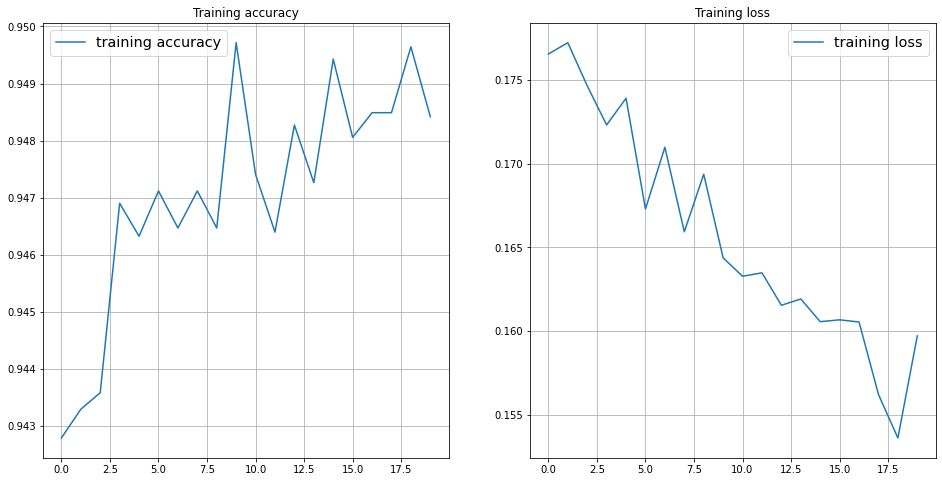

In [9]:
hist         = history.history
epochs_range = range(len(hist['loss']))

plt.figure(figsize=(16, 8))
if 'val_loss' in hist:
    for idx, metric in enumerate(['accuracy', 'loss']):
        train_metric = hist[metric]
        val_metric   = hist[f'val_{metric}']

        plt.subplot(1, 2, idx+1)
        plt.plot(epochs_range, train_metric, label=f'training {metric}')
        plt.plot(epochs_range, val_metric, label=f'validation {metric}')
        plt.legend(fontsize='x-large');  plt.grid()
        plt.title(f'Training and Validation {metric}')
else:
    for idx, metric in enumerate(['accuracy', 'loss']):
        train_metric = hist[metric]
#         val_metric   = hist[f'val_{metric}']

        plt.subplot(1, 2, idx+1)
        plt.plot(epochs_range, train_metric, label=f'training {metric}')
#         plt.plot(epochs_range, val_metric, label=f'validation {metric}')
        plt.legend(fontsize='x-large');  plt.grid()
        plt.title(f'Training {metric}')
    
plt.show()

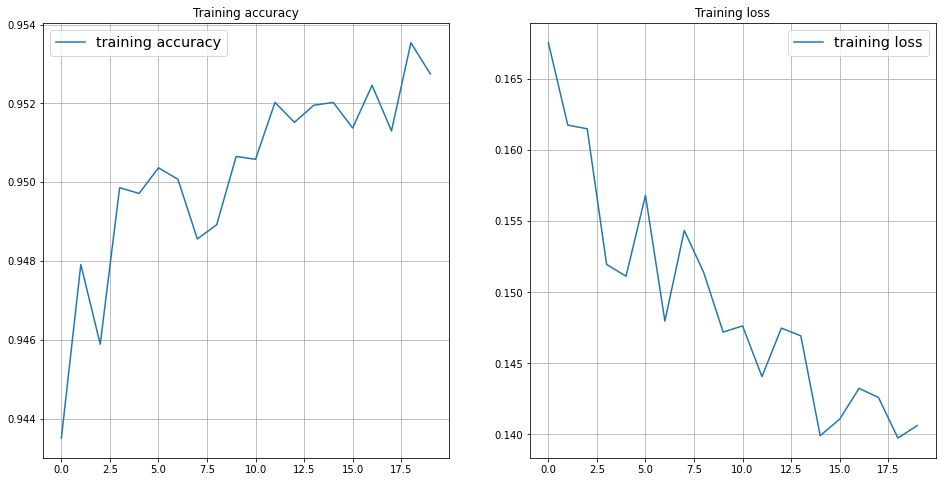

In [13]:
hist         = history.history
epochs_range = range(len(hist['loss']))

plt.figure(figsize=(16, 8))
if 'val_loss' in hist:
    for idx, metric in enumerate(['accuracy', 'loss']):
        train_metric = hist[metric]
        val_metric   = hist[f'val_{metric}']

        plt.subplot(1, 2, idx+1)
        plt.plot(epochs_range, train_metric, label=f'training {metric}')
        plt.plot(epochs_range, val_metric, label=f'validation {metric}')
        plt.legend(fontsize='x-large');  plt.grid()
        plt.title(f'Training and Validation {metric}')
else:
    for idx, metric in enumerate(['accuracy', 'loss']):
        train_metric = hist[metric]
#         val_metric   = hist[f'val_{metric}']

        plt.subplot(1, 2, idx+1)
        plt.plot(epochs_range, train_metric, label=f'training {metric}')
#         plt.plot(epochs_range, val_metric, label=f'validation {metric}')
        plt.legend(fontsize='x-large');  plt.grid()
        plt.title(f'Training {metric}')
    
plt.show()

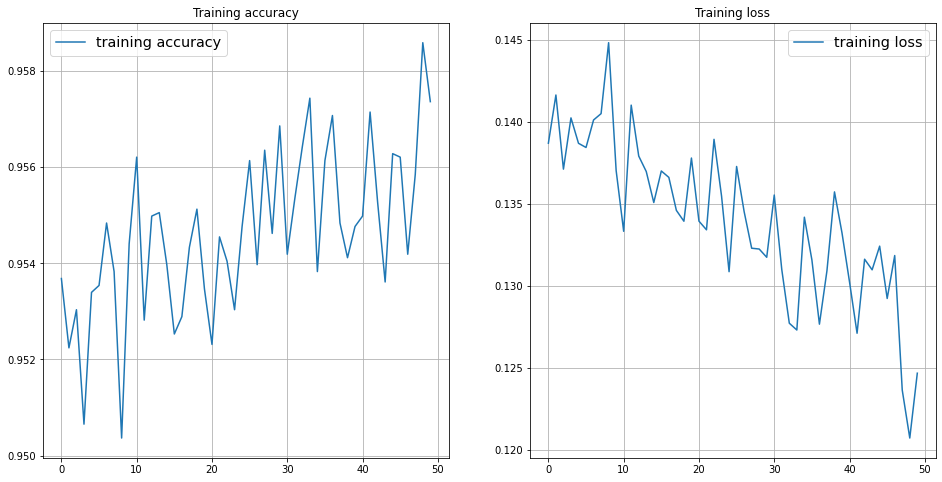

In [15]:
hist         = history.history
epochs_range = range(len(hist['loss']))

plt.figure(figsize=(16, 8))
if 'val_loss' in hist:
    for idx, metric in enumerate(['accuracy', 'loss']):
        train_metric = hist[metric]
        val_metric   = hist[f'val_{metric}']

        plt.subplot(1, 2, idx+1)
        plt.plot(epochs_range, train_metric, label=f'training {metric}')
        plt.plot(epochs_range, val_metric, label=f'validation {metric}')
        plt.legend(fontsize='x-large');  plt.grid()
        plt.title(f'Training and Validation {metric}')
else:
    for idx, metric in enumerate(['accuracy', 'loss']):
        train_metric = hist[metric]
#         val_metric   = hist[f'val_{metric}']

        plt.subplot(1, 2, idx+1)
        plt.plot(epochs_range, train_metric, label=f'training {metric}')
#         plt.plot(epochs_range, val_metric, label=f'validation {metric}')
        plt.legend(fontsize='x-large');  plt.grid()
        plt.title(f'Training {metric}')
    
plt.show()

In [ ]:
hist         = history.history
epochs_range = range(len(hist['loss']))

plt.figure(figsize=(16, 8))
for idx, metric in enumerate(['accuracy', 'loss']):
    train_metric = hist[metric]
    val_metric   = hist[f'val_{metric}']
    
    plt.subplot(1, 2, idx+1)
    plt.plot(epochs_range, train_metric, label=f'training {metric}')
    plt.plot(epochs_range, val_metric, label=f'validation {metric}')
    plt.legend(fontsize='x-large');  plt.grid()
    plt.title(f'Training and Validation {metric}')
    
plt.show()

In [ ]:
# base_model.trainable = True


# # Let's take a look to see how many layers are in the base model
# print("Number of layers in the base model: ", len(base_model.layers))

# # Fine-tune from this layer onwards
# fine_tune_at = 100

# # Freeze all the layers before the `fine_tune_at` layer
# for layer in base_model.layers[:fine_tune_at]:
#     layer.trainable = False


# # optimizer = keras.optimizers.RMSprop(learning_rate=base_learning_rate)
# optimizer = 'adam'
# model.compile(optimizer=optimizer, loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
# model.summary()

In [ ]:
# fine_tune_epochs = 100
# total_epochs = epochs + fine_tune_epochs

# history = model.fit(
#     train_ds, validation_data=val_ds, epochs=total_epochs, initial_epoch=history.epoch[-1],
#     callbacks=[EarlyStopping(monitor='val_loss', mode='min', patience=10)]
# )

In [ ]:
# hist         = history.history
# epochs_range = range(len(hist['loss']))

# plt.figure(figsize=(16, 8))
# for idx, metric in enumerate(['accuracy', 'loss']):
#     train_metric = hist[metric]
#     val_metric   = hist[f'val_{metric}']
    
#     plt.subplot(1, 2, idx+1)
#     plt.plot(epochs_range, train_metric, label=f'training {metric}')
#     plt.plot(epochs_range, val_metric, label=f'validation {metric}')
#     plt.legend(fontsize='x-large');  plt.grid()
#     plt.title(f'Training and Validation {metric}')
    
# plt.show()

In [ ]:
data_dir = join(PATH.INPUT, 'test')

img_arrays = []
names      = []
for path, name in sorted(list_files(data_dir), key=lambda e: int(''.join(filter(str.isdigit, e[1])))):
    img = keras.preprocessing.image.load_img(path, target_size=img_size)
    img_array = keras.preprocessing.image.img_to_array(img)
    img_arrays.append(img_array)
    names.append(name)
img_arrays = np.array(img_arrays)

predictions = model.predict(img_arrays)
predictions = np.argmax(predictions, axis=1)

sub = pd.DataFrame({'file_name': names, 'answer': predictions})
output_path = join(PATH.OUTPUT, f'{exp_name}.csv')
sub.to_csv(output_path, index=None)